In [159]:
import torch

from sbi.analysis import pairplot
from sbi.utils import BoxUniform
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)


In [160]:
import sys
sys.path.append('../Matlab2Py/')

from mat_engine import Engine

import numpy as np
import random


def init_simulator(SIMULATION_PATH, model_name, simulation_type='normal', ):
    #Here you setup your simulation configuration & initalzie necessary variables 


    MODEL_PATH = f"{SIMULATION_PATH}{model_name}.slx"
    
    eng = Engine(model_path = MODEL_PATH, sim_path = SIMULATION_PATH, model_name = model_name, simulation_type=simulation_type)
    eng.load_engine()
    #Run the simple_sim/init.m to initalize theta
    eng.run_engine_script('init')
    eng.set_simulation_mode(s_mode='Normal')

    if eng.sim_type == 'sparsesbs':
        # 1 second
        STEP_SIZE = 1
        eng.set_step_size(STEP_SIZE)  
    return eng

SIMULATION_PATH = 'simple_sim/'
model_name = 'test'
eng = init_simulator(SIMULATION_PATH=SIMULATION_PATH, model_name=model_name)

num_dim = 3

In [161]:



def run_simulation(eng, theta : list[3]):
    if type(theta) == torch.Tensor:
        theta = theta.tolist()
    
    seeds = np.random.randint(0, np.iinfo(np.int32).max, size = num_dim)
    eng.set_param(block_path = "gau", value = str(seeds), type = "seed", )
    eng.set_param(block_path = "theta", value = theta )
    
    eng.start_simulation()
    return eng.get_ws_value(attribute = 'out.simout')

def simulator(eng):
    def _simulator(inputs):
        output = (torch.Tensor(run_simulation(eng, theta)).squeeze() for theta in inputs)
        return torch.stack((*output,) )
    return _simulator


simul = simulator(eng)

In [162]:

def simulator(theta):
    # linear gaussian
    print(theta + 1.0 + torch.randn_like(theta) * 0.1)
    return theta + 1.0 + torch.randn_like(theta) * 0.1

prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simul = process_simulator(simul, prior, prior_returns_numpy)


In [163]:
check_sbi_inputs(simul, prior)


In [164]:
theta, x = simulate_for_sbi(simul, proposal=prior, num_simulations=2000)
print("theta", theta.shape)
print("x", x.shape)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.: 100%|██████████| 2000/2000 [04:24<00:00,  7.55it/s]

theta torch.Size([2000, 3])
x torch.Size([2000, 3])


In [165]:
inference = SNPE(prior=prior)


In [166]:
inference = inference.append_simulations(theta, x)


In [167]:
density_estimator = inference.train()


 Neural network successfully converged after 121 epochs.

In [168]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [169]:
theta_true = prior.sample((1,))
# generate our observation
x_obs = simul(theta_true)

Drawing 10000 posterior samples: 10177it [00:00, 44755.27it/s]                          


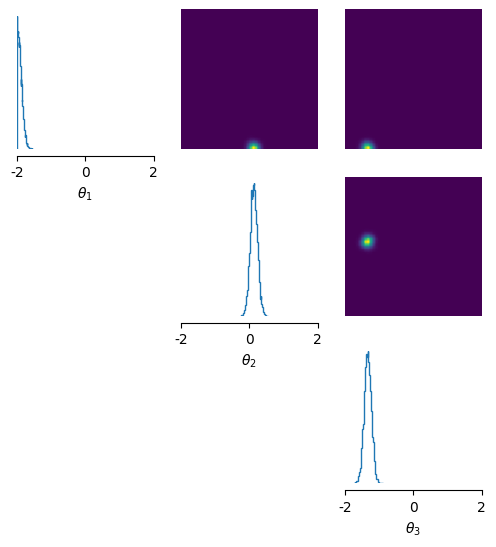

In [170]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6),labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])


Drawing 10000 posterior samples: 10107it [00:00, 50493.27it/s]                          


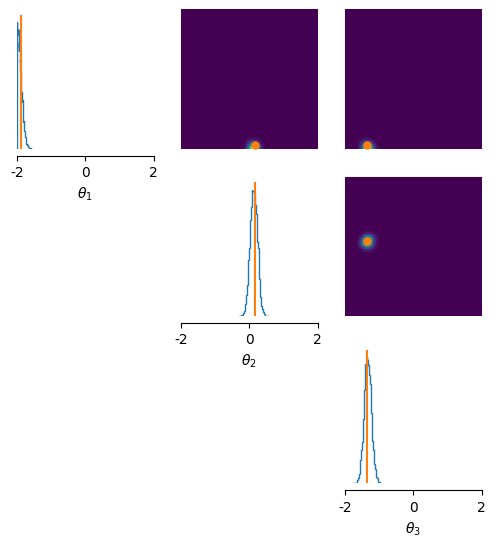

In [171]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [172]:
# first sample an alternative parameter set from the prior
theta_diff = prior.sample((1,))

In [173]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_obs)
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_obs)
log_probability_samples = posterior.log_prob(samples, x=x_obs)

print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))

high for true theta : tensor([3.9381])
low for different theta : tensor([-68.8546])
range of posterior samples: min: tensor(-6.2283)  max : tensor(4.6088)
